In [7]:
import sys, json
from Reader import Reader
import time

In [273]:
WF = 'USGS_Wildland_Fire_Combined_Dataset.json'
wf_reader = Reader(WF)
header = wf_reader.header()
print(header)

{'displayFieldName': '', 'fieldAliases': {'OBJECTID': 'OBJECTID', 'USGS_Assigned_ID': 'USGS Assigned ID', 'Assigned_Fire_Type': 'Assigned Fire Type', 'Fire_Year': 'Fire Year', 'Fire_Polygon_Tier': 'Fire Polygon Tier', 'Fire_Attribute_Tiers': 'Fire Attribute Tiers', 'GIS_Acres': 'GIS_Acres', 'GIS_Hectares': 'GIS_Hectares', 'Source_Datasets': 'Source Datasets', 'Listed_Fire_Types': 'Listed Fire Types', 'Listed_Fire_Names': 'Listed Fire Names', 'Listed_Fire_Codes': 'Listed Fire Codes', 'Listed_Fire_IDs': 'Listed Fire IDs', 'Listed_Fire_IRWIN_IDs': 'Listed Fire IRWIN IDs', 'Listed_Fire_Dates': 'Listed Fire Dates', 'Listed_Fire_Causes': 'Listed Fire Causes', 'Listed_Fire_Cause_Class': 'Listed Fire Cause Class', 'Listed_Rx_Reported_Acres': 'Listed Rx Reported Acres', 'Listed_Map_Digitize_Methods': 'Listed Map Digitize Methods', 'Listed_Notes': 'Listed Notes', 'Processing_Notes': 'Processing Notes', 'Wildfire_Notice': 'Wildfire Notice', 'Prescribed_Burn_Notice': 'Prescribed Burn Notice', 'Wil

In [274]:
from shapely.geometry import Polygon, Point
from math import radians, sin, cos, sqrt, atan2
import re
from datetime import datetime

# Initialize variables
found_count = 0
feature_count = 0
assigned_city = (40.3955, -105.0746)  # Latitude, Longitude
feature_list = []

# Function to extract date from the 'Listed_Fire_Dates' field
def extract_date(date_str):
    if not isinstance(date_str, str):
        return None
    match = re.search(r'\d{4}-\d{2}-\d{2}', date_str)
    if match:
        return datetime.strptime(match.group(0), '%Y-%m-%d')
    return None

# Haversine distance function
def haversine(coord1, coord2):
    R = 3958.8  # Earth radius in miles
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return R * c


In [282]:
import time
wf_reader = Reader(WF)
feature = wf_reader.next()

while feature:
    feature_count += 1
    
    fire_year = feature['attributes']['Fire_Year']
    fire_type = feature['attributes']['Listed_Fire_Types']
    wf = 'Wildfire' in fire_type
    if 1963 <= fire_year <= 2023 and wf:
        # Filter by Date
        fire_date_str = feature['attributes']['Listed_Fire_Dates']
        fire_date = extract_date(fire_date_str)
        if fire_date and fire_date.month in range(5, 11):
            
            # Filter by Distance
            geometry = feature.get('geometry', {})
            if 'rings' in geometry:
                rings = geometry['rings']
                fire_polygon = Polygon(rings[0])  # Assuming each fire is represented by one ring
                fire_centroid = fire_polygon.centroid
                distance = haversine((fire_centroid.y, fire_centroid.x), assigned_city)
                
                if distance <= 1250:
                    found_count += 1
                    if found_count % 100 == 0:
                        print(found_count)
                    feature_list.append(feature)  # Storing the filtered feature
                
    feature = wf_reader.next()

print(f"Total Features: {feature_count}")
print(f"Features meeting criteria: {found_count}")

200
300
400
500
600
700
800
900
1000
1100
1200
Total Features: 183897
Features meeting criteria: 1225


In [25]:
with open('filtered_features_final.json', 'w') as f:
    json.dump(feature_list, f)

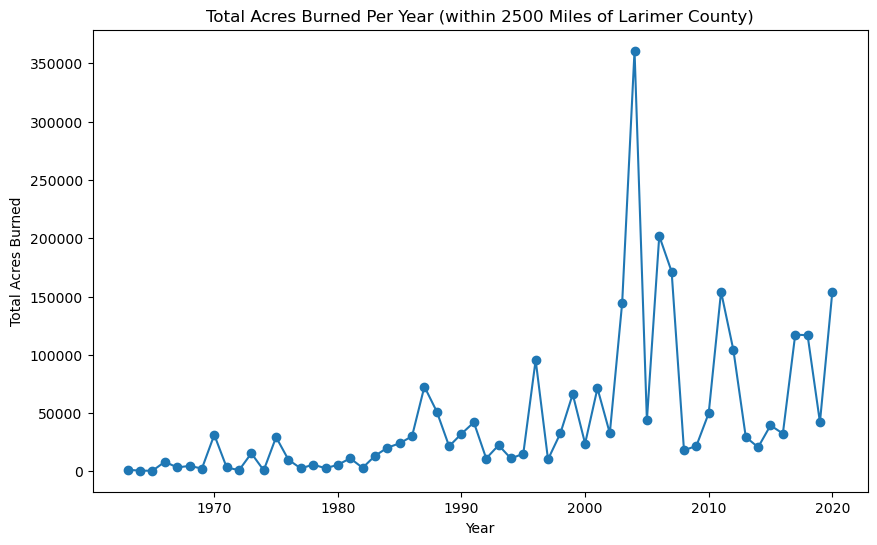

In [296]:
from shapely.geometry import Polygon
import math
# Variables to hold data for analysis
distance_acres_data = {}  # {distance: total_acres}
year_acres_data = {}  # {year: total_acres}

# Loop through each fire record to populate the data variables
for feature in feature_list:
    attributes = feature['attributes']
    
    polygon = Polygon(polygon)
    area = polygon.area
    acres_burned = attributes['GIS_Acres']
    
    # Update year_acres_data
    fire_year = attributes['Fire_Year']
    if fire_year not in year_acres_data:
        year_acres_data[fire_year] = 0
    year_acres_data[fire_year] += acres_burned


sorted_years = sorted(list(year_acres_data.keys()))

acres_by_year = [year_acres_data[year] for year in sorted_years]

sorted_years, acres_by_year

plt.figure(figsize=(10, 6))
plt.plot(list(sorted_years), list(acres_by_year), marker='o')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned Per Year (within 1250 Miles of Larimer County)')
plt.show()


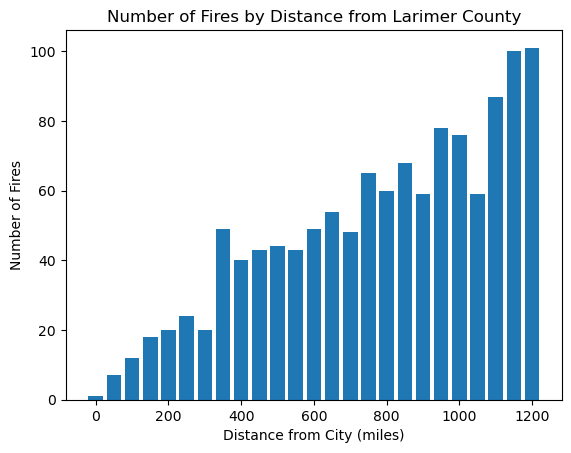

In [307]:
from collections import Counter
# Your assigned city coordinates
assigned_city = (40.3955, -105.0746)

# Initialize a list to store distances
distances = []

# Loop through each feature to calculate the distance and add it to the list
for feature in feature_list:
    geometry = feature.get('geometry', {})
    rings = geometry['rings']
    fire_polygon = Polygon(rings[0])  # Assuming each fire is represented by one ring
    fire_centroid = fire_polygon.centroid
    distance = haversine((fire_centroid.y, fire_centroid.x), assigned_city)
    # Append to list
    distances.append(distance)

# Create buckets for every 50 miles
buckets = [int(d // 50 * 50) for d in distances]

# Count the number of fires in each bucket
bucket_counts = Counter(buckets)

# Create the histogram
plt.bar(bucket_counts.keys(), bucket_counts.values(), width=40)
plt.xlabel('Distance from City (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires by Distance from Larimer County')
plt.show()


In [285]:
from collections import defaultdict

# Initialize a dictionary to hold the annual smoke estimates
annual_smoke_estimate = defaultdict(float)

for feature in feature_list:
    fire_year = feature['attributes']['Fire_Year']
    fire_acres = feature['attributes']['GIS_Acres']
    
    geometry = feature.get('geometry', {})
    if 'rings' in geometry:
        rings = geometry['rings']
        fire_polygon = Polygon(rings[0])
        fire_centroid = fire_polygon.centroid
        distance = haversine((fire_centroid.y, fire_centroid.x), assigned_city)
        
        # Using the formula to estimate smoke for this particular fire
        if distance > 0:  # To avoid division by zero
            smoke_estimate = fire_acres / (distance ** 2) 
            
            # Accumulate the smoke estimates annually
            annual_smoke_estimate[fire_year] += smoke_estimate

# Now, annual_smoke_estimate holds the cumulative smoke estimate for each year
print(annual_smoke_estimate)

defaultdict(<class 'float'>, {1963: 0.03835663018524231, 1964: 0.0004948018336509065, 1965: 0.001039115108317652, 1966: 0.14282885499170647, 1967: 0.00241552779413955, 1968: 0.005244029563056777, 1969: 0.006976102922769398, 1970: 0.05480960039513906, 1971: 0.012242297711757007, 1972: 0.0027272098055454376, 1973: 0.06783352761128597, 1974: 0.0013821167004008101, 1975: 0.19579221295274535, 1976: 0.017771908128360676, 1977: 0.0051544886400033, 1978: 0.008693377995633793, 1979: 0.002533672184353894, 1980: 0.006805369281978984, 1981: 0.03094921619437736, 1982: 0.0023180067646168434, 1983: 0.02016936513146498, 1984: 0.058951048062511995, 1985: 0.03889300000437698, 1986: 0.18521056025778418, 1987: 0.17516753819422007, 1988: 0.0647359581159999, 1989: 0.027338872224404204, 1990: 0.07227847779400662, 1991: 0.06250234158055312, 1992: 0.011163924343920906, 1993: 0.02564656514829152, 1994: 0.09043316780990412, 1995: 0.054145439877088246, 1996: 0.17087162416671628, 1997: 0.020398094769063648, 1998: 

In [27]:
import requests
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}


In [35]:
USERNAME = "petermohammadi@gmail.com"
APIKEY = 'goldgazelle23'
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

In [90]:
CITY_LOCATIONS = {
    'mine' :       {'city'   : 'Loveland',
                       'county' : 'Larimer',
                       'state'  : 'Colorado',
                       'fips'   : '08069',
                       'latlon' : [40.3955, -105.0746] }
}
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [91]:
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result
extract_gaseous = extract_summary_from_response(gaseous_aqi)
print("Summary of gaseous extraction ...")
#with open('extract_gaseous.json', 'w') as f:
#    json.dump(extract_gaseous, f)
print(json.dumps(extract_gaseous,indent=4))

extract_particulate = extract_summary_from_response(particulate_aqi)
print("Summary of particulate extraction ...")
#with open('extract_particulate.json', 'w') as f:
#    json.dump(extract_particulate, f)
print(json.dumps(extract_particulate,indent=4))

Summary of gaseous extraction ...
{
    "0001": {
        "local_site_name": null,
        "site_address": "200 W. OAK ST.",
        "state": "Colorado",
        "county": "Larimer",
        "city": "Fort Collins",
        "pollutant_type": {
            "42101": {
                "parameter_name": "Carbon monoxide",
                "units_of_measure": "Parts per million",
                "method": "INSTRUMENTAL - NONDISPERSIVE INFRARED",
                "data": {
                    "19750101": [
                        {
                            "sample_duration": "1 HOUR",
                            "observation_count": 24,
                            "arithmetic_mean": 3.708333,
                            "aqi": null
                        },
                        {
                            "sample_duration": "8-HR RUN AVG END HOUR",
                            "observation_count": 19,
                            "arithmetic_mean": 3.684211,
                            "

In [151]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['mine']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['mine']['fips'][2:]

# Sample function to pull air quality data and store it into JSON files
def fetch_and_store_aqi_data(start_year=1975, end_year=2023):
    # Initialize dictionaries to hold the AQI data
    gaseous_aqi_data = {}
    particulate_aqi_data = {}

    # Loop through each year and fire season (May 1st to October 31st)
    for year in range(start_year, end_year + 1):
        begin_date = f"{year}0501"
        end_date = f"{year}1031"
        
        request_data['param'] = AQI_PARAMS_GASEOUS
        # Assuming request_daily_summary and extract_summary_from_response are your existing functions
        gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
        
        request_data['param'] = AQI_PARAMS_PARTICULATES
        particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
        
        # Extract and organize the AQI data
        extract_gaseous = extract_summary_from_response(gaseous_aqi)
        extract_particulate = extract_summary_from_response(particulate_aqi)
        
        # Store the extracted data into dictionaries
        gaseous_aqi_data[year] = extract_gaseous
        particulate_aqi_data[year] = extract_particulate

    # Save the dictionaries to JSON files
    with open('gaseous_aqi_data.json', 'w') as f:
        json.dump(gaseous_aqi_data, f)
        
    with open('particulate_aqi_data.json', 'w') as f:
        json.dump(particulate_aqi_data, f)

fetch_and_store_aqi_data()

In [152]:
import numpy as np

# Load AQI and smoke data
with open('gaseous_aqi_data.json', 'r') as f:
    gaseous_aqi_data = json.load(f)
with open('particulate_aqi_data.json', 'r') as f:
    particulate_aqi_data = json.load(f)
aggregated_data = {}

for year, year_data in gaseous_aqi_data.items():
    for site_id, site_data in year_data.items():
        for pollutant_id, pollutant_data in site_data['pollutant_type'].items():
            for date, measurements in pollutant_data['data'].items():
                year = date[:4]
                if year not in aggregated_data:
                    aggregated_data[year] = {}
                if pollutant_id not in aggregated_data[year]:
                    aggregated_data[year][pollutant_id] = []
                for measurement in measurements:
                    aqi_value = measurement.get('aqi', None)
                    if aqi_value is not None:
                        aggregated_data[year][pollutant_id].append(aqi_value)

for year, year_data in particulate_aqi_data.items():
    for site_id, site_data in year_data.items():
        for pollutant_id, pollutant_data in site_data['pollutant_type'].items():
            for date, measurements in pollutant_data['data'].items():
                year = date[:4]
                if year not in aggregated_data:
                    aggregated_data[year] = {}
                if pollutant_id not in aggregated_data[year]:
                    aggregated_data[year][pollutant_id] = []
                for measurement in measurements:
                    aqi_value = measurement.get('aqi', None)
                    if aqi_value is not None:
                        aggregated_data[year][pollutant_id].append(aqi_value)


# Calculate average AQI per year for each pollutant
average_aqi_per_year = defaultdict(dict)

for year, pollutants in aggregated_data.items():
    for pollutant_id, aqi_values in pollutants.items():
        average_aqi = np.mean(aqi_values)
        average_aqi_per_year[year][pollutant_id] = round(average_aqi, 2)

average_aqi_per_year

defaultdict(dict,
            {'1975': {'42101': 81.2, '44201': 116.77},
             '1976': {'42101': 24.27},
             '1978': {'44201': 60.82},
             '1979': {'44201': 58.12},
             '1980': {'42101': 30.2, '44201': 40.35},
             '1981': {'42101': 25.96, '44201': 39.94},
             '1982': {'42101': 21.88, '44201': 37.42},
             '1983': {'42101': 22.28, '44201': 44.64},
             '1984': {'42101': 21.38, '44201': 42.02},
             '1985': {'42101': 24.79, '44201': 39.96},
             '1986': {'42101': 22.12, '44201': 39.08, '81102': 28.23},
             '1987': {'42101': 20.66, '44201': 45.6, '81102': 26.54},
             '1988': {'42101': 22.32,
              '44201': 51.44,
              '81102': 23.79,
              '88502': 17.33},
             '1989': {'42101': 21.32,
              '44201': 47.99,
              '81102': 28.25,
              '88502': 19.37},
             '1990': {'42101': 17.91,
              '44201': 41.99,
              

In [154]:
# Define pollutant code mappings
pollutant_code_mapping = {
    '42101': 'CO',
    '42401': 'SO2',
    '42602': 'NO2',
    '44201': 'O2',
    '81102': 'PM10',
    '88101': 'PM2.5',
    '88502': 'Acceptable PM2.5'
}

# Function to rename keys in the dictionary based on the mapping
def rename_keys(dictionary, mapping):
    return {mapping.get(key, key): value for key, value in dictionary.items()}

# Assuming `aggregated_data` contains the data aggregated by year and pollutant code
# Replace the keys in the aggregated_data
renamed_aggregated_data = {year: rename_keys(year_data, pollutant_code_mapping) for year, year_data in average_aqi_per_year.items()}

renamed_aggregated_data


{'1975': {'CO': 81.2, 'O2': 116.77},
 '1976': {'CO': 24.27},
 '1978': {'O2': 60.82},
 '1979': {'O2': 58.12},
 '1980': {'CO': 30.2, 'O2': 40.35},
 '1981': {'CO': 25.96, 'O2': 39.94},
 '1982': {'CO': 21.88, 'O2': 37.42},
 '1983': {'CO': 22.28, 'O2': 44.64},
 '1984': {'CO': 21.38, 'O2': 42.02},
 '1985': {'CO': 24.79, 'O2': 39.96},
 '1986': {'CO': 22.12, 'O2': 39.08, 'PM10': 28.23},
 '1987': {'CO': 20.66, 'O2': 45.6, 'PM10': 26.54},
 '1988': {'CO': 22.32, 'O2': 51.44, 'PM10': 23.79, 'Acceptable PM2.5': 17.33},
 '1989': {'CO': 21.32, 'O2': 47.99, 'PM10': 28.25, 'Acceptable PM2.5': 19.37},
 '1990': {'CO': 17.91, 'O2': 41.99, 'PM10': 21.67, 'Acceptable PM2.5': 20.15},
 '1991': {'CO': 12.39,
  'O2': 49.27,
  'SO2': nan,
  'PM10': 20.48,
  'Acceptable PM2.5': 16.81},
 '1992': {'CO': 13.78, 'O2': 46.29, 'PM10': 20.92, 'Acceptable PM2.5': 19.06},
 '1993': {'CO': 11.59,
  'O2': 44.91,
  'SO2': nan,
  'PM10': 17.32,
  'Acceptable PM2.5': 16.91},
 '1994': {'CO': 12.99,
  'O2': 48.76,
  'SO2': nan,
 

In [286]:
# Extract PM2.5 and Ozone (O3) data for each year
pm25_data = {}
ozone_data = {}
pm10_data = {}
# The pollutant IDs for PM2.5 and Ozone based on the provided data
pm25_id = 'PM2.5'
ozone_id = 'O2' 
pm10_id = 'PM10'
# Extract PM2.5 data
for year, data in renamed_aggregated_data.items():
    if pm25_id in data:
        pm25_data[year] = data[pm25_id]
        
for year, data in renamed_aggregated_data.items():
    if pm10_id in data:
        pm10_data[year] = data[pm10_id]
# Extract Ozone data
#for year, data in renamed_aggregated_data.items():
#    if ozone_id in data:
#        ozone_data[year] = data[ozone_id]
    
comparison_data = {}
for year, estimate in annual_smoke_estimate.items():
    comparison_data[year] = {
        'estimated': estimate,
        'pm25': pm25_data.get(str(year), None),
 #       'ozone': ozone_data.get(str(year), None),
        'pm10': pm10_data.get(str(year), None)
    }
print(comparison_data)

{1963: {'estimated': 0.03835663018524231, 'pm25': None, 'pm10': None}, 1964: {'estimated': 0.0004948018336509065, 'pm25': None, 'pm10': None}, 1965: {'estimated': 0.001039115108317652, 'pm25': None, 'pm10': None}, 1966: {'estimated': 0.14282885499170647, 'pm25': None, 'pm10': None}, 1967: {'estimated': 0.00241552779413955, 'pm25': None, 'pm10': None}, 1968: {'estimated': 0.005244029563056777, 'pm25': None, 'pm10': None}, 1969: {'estimated': 0.006976102922769398, 'pm25': None, 'pm10': None}, 1970: {'estimated': 0.05480960039513906, 'pm25': None, 'pm10': None}, 1971: {'estimated': 0.012242297711757007, 'pm25': None, 'pm10': None}, 1972: {'estimated': 0.0027272098055454376, 'pm25': None, 'pm10': None}, 1973: {'estimated': 0.06783352761128597, 'pm25': None, 'pm10': None}, 1974: {'estimated': 0.0013821167004008101, 'pm25': None, 'pm10': None}, 1975: {'estimated': 0.19579221295274535, 'pm25': None, 'pm10': None}, 1976: {'estimated': 0.017771908128360676, 'pm25': None, 'pm10': None}, 1977: {'

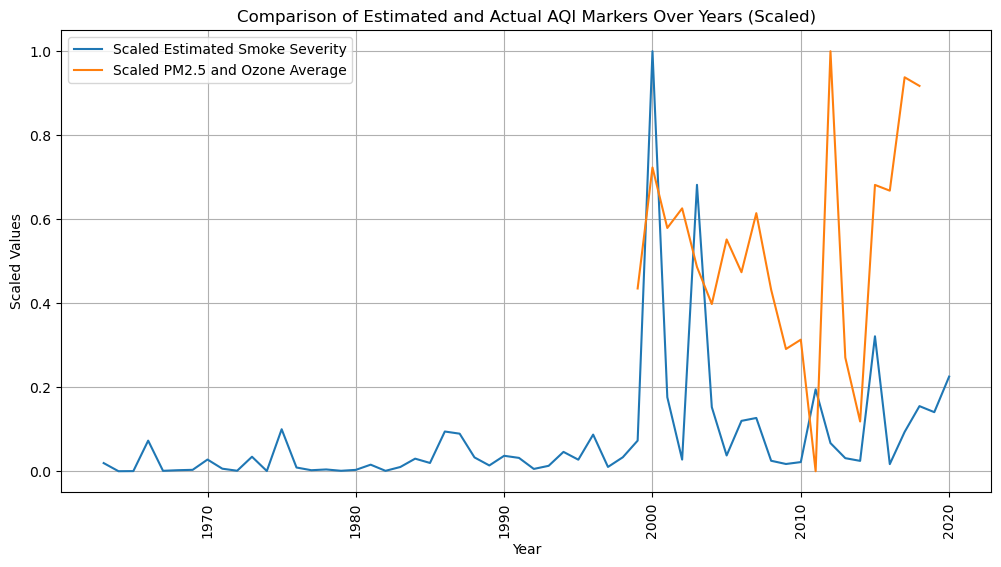

In [287]:
import matplotlib.pyplot as plt
import numpy as np


def minmax_scale(data):
    data = np.array(data)  # Convert to numpy array if it's not already
    nan_mask = np.isnan(data)
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    scaled_data[nan_mask] = np.nan  # Restore NaN values
    return scaled_data


# Sorting by year for plotting
years = sorted(comparison_data.keys(), key=int)

# Initialize lists for plotting
estimated_values = []
pm25_values = []
ozone_values = []
avg_val = []

for year in years:
    data = comparison_data[year]
    estimated_values.append(data.get('estimated', np.nan))

    pm25 = data.get('pm25', np.nan)
    ozone = data.get('pm10', np.nan)
    pm25_values.append(pm25)
    ozone_values.append(ozone)

    if pm25 is not None and ozone is not None:
        avg_val.append((pm25 + ozone) / 2)

    else:
        avg_val.append(np.nan)

scaled_estimated_values = minmax_scale(np.array(estimated_values))
scaled_avg_val = minmax_scale(np.array(avg_val))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(years, scaled_estimated_values, label='Scaled Estimated Smoke Severity')
plt.plot(years, scaled_avg_val, label='Scaled PM2.5 and Ozone Average')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Scaled Values')
plt.title('Comparison of Estimated and Actual AQI Markers Over Years (Scaled)')
plt.legend()
plt.grid(True)
plt.show()


In [288]:
# Remove NaN values from both lists while keeping pairs intact
filtered_estimated_values, filtered_avg_val = [], []
for est, avg in zip(estimated_values, avg_val):
    if np.isnan(est) or np.isnan(avg):
        continue
    filtered_estimated_values.append(est)
    filtered_avg_val.append(avg)

# Compute the correlation
correlation = np.corrcoef(filtered_estimated_values, filtered_avg_val)[0, 1]
correlation


0.17353509040243925